In [ ]:
#Install necessary libraries:
#TensorFlow, Spektral (for graph neural networks)
#Pandas (data handling)
#RDKit (molecular processing)
#NumPy (numerical operations)
#Matplotlib (visualization)
!pip install tensorflow spektral pandas rdkit numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 52.1 MB/s eta 0:00:00


In [ ]:
# Upload dataset to the Colab environment using the file upload dialog.
from google.colab import files
uploaded = files.upload()

Saving qm9_subset.csv to qm9_subset.csv


In [ ]:
# Import Pandas for data manipulation and analysis.
import pandas as pd
# Import RDKit for handling molecular structures and operations.
from rdkit import Chem
from rdkit.Chem import rdmolops
# Import NumPy for numerical operations.
import numpy as np
# Import TensorFlow for building and training the neural network.
import tensorflow as tf
# Import Spektral components for creating datasets, defining graph convolutional layers, pooling layers, and data loaders.
from spektral.data import Dataset, Graph
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data.loaders import DisjointLoader
# Import function to split the dataset into training and validation sets.
from sklearn.model_selection import train_test_split
# Import Spektral for graph neural network utilities.
import spektral
# Import Matplotlib for creating plots.
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/qm9_subset.csv')
# Load the QM9 dataset from the uploaded CSV file into a Pandas DataFrame.

In [ ]:
df.head()
# Display the first 5 rows of the DataFrame to get an overview of the data.

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_3116,N#CC12CC1CO2,5.99438,2.27301,1.94738,4.5933,55.81,-0.2627,-0.0086,0.2541,...,0.090625,-323.338627,-323.332830,-323.331885,-323.368166,21.459,-1226.756250,-1233.784350,-1240.302914,-1147.410874
1,gdb_117880,COCC(O)C#CC=O,2.32923,0.75737,0.59946,3.4068,77.34,-0.2697,-0.0657,0.2040,...,0.131823,-458.914682,-458.903948,-458.903004,-458.952489,35.183,-1655.449691,-1663.823171,-1673.306087,-1542.777940
2,gdb_23434,COC1C2CC(=NO)C12,2.71950,1.23126,1.02616,1.2920,76.75,-0.2258,0.0156,0.2414,...,0.146098,-438.996978,-438.988148,-438.987204,-439.030829,32.710,-1694.820233,-1705.277043,-1715.352955,-1572.928492
3,gdb_61956,CC(CC=O)OCC#C,2.29944,0.85305,0.65285,3.1488,79.50,-0.2438,-0.0199,0.2239,...,0.154138,-422.988608,-422.977883,-422.976938,-423.026195,36.895,-1838.172154,-1848.329015,-1858.997295,-1712.247413
4,gdb_98812,COC(=N)N1CCC1=N,3.03493,1.26316,0.90731,1.9135,77.81,-0.2343,0.0056,0.2400,...,0.147974,-435.272093,-435.262958,-435.262014,-435.306724,32.448,-1706.582262,-1716.847054,-1726.922966,-1584.819788


In [ ]:
df.shape
# Print the number of rows and columns in the DataFrame.

(10000, 21)

In [ ]:
df.describe()
# Display the data types of each column in the DataFrame.

,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.432751,1.414028,1.134979,2.709174,75.310614,-0.239712,0.011650,0.251362,1190.900778,0.148882,-411.151471,-411.142994,-411.142050,-411.184886,31.638306,-1753.475093,-1764.168056,-1774.253463,-1631.837792
std,2.131450,1.633652,1.602657,1.544192,8.128894,0.022120,0.046978,0.047853,280.917619,0.033182,40.215128,40.214891,40.214891,40.215670,4.077117,238.782518,240.895997,242.606474,219.728846
min,0.000000,0.357840,0.344070,0.000000,13.210000,-0.387700,-0.150300,0.078900,35.364100,0.020349,-600.333714,-600.325436,-600.324492,-600.368167,6.469000,-2492.445040,-2510.160874,-2525.573750,-2311.622674
25%,2.552730,1.089193,0.908648,1.602950,70.640000,-0.252400,-0.023225,0.216200,1018.504850,0.125523,-437.892216,-437.884546,-437.883602,-437.926762,29.030750,-1907.363649,-1919.626901,-1930.650351,-1773.908330
50%,3.099285,1.366220,1.076350,2.489150,75.710000,-0.240800,0.012900,0.250300,1150.470000,0.148759,-416.870648,-416.863579,-416.862635,-416.902913,31.610500,-1760.168393,-1770.927348,-1781.067894,-1638.416273
75%,3.843967,1.655242,1.279842,3.631625,80.602500,-0.228100,0.050000,0.288925,1312.492750,0.171363,-387.048486,-387.039254,-387.038310,-387.082652,34.344000,-1599.698810,-1609.086502,-1618.342887,-1491.094573
max,157.711800,157.709970,157.706990,21.512000,112.770000,-0.117700,0.117100,0.504800,2975.378300,0.253798,-40.478930,-40.476062,-40.475117,-40.498597,45.934000,-395.999595,-398.643290,-401.014647,-372.471772


In [ ]:
df.dtypes
# Display the data types of each column in the DataFrame.

mol_id        object
smiles        object
A            float64
B            float64
C            float64
mu           float64
alpha        float64
homo         float64
lumo         float64
gap          float64
r2           float64
zpve         float64
u0           float64
u298         float64
h298         float64
g298         float64
cv           float64
u0_atom      float64
u298_atom    float64
h298_atom    float64
g298_atom    float64
dtype: object

In [ ]:
df.isnull().sum()
# Calculate and display the number of missing values in each column to check for any null data.

mol_id       0
smiles       0
A            0
B            0
C            0
mu           0
alpha        0
homo         0
lumo         0
gap          0
r2           0
zpve         0
u0           0
u298         0
h298         0
g298         0
cv           0
u0_atom      0
u298_atom    0
h298_atom    0
g298_atom    0
dtype: int64

In [ ]:
# Function to convert SMILES to graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles) # Convert a SMILES string to an RDKit molecule object.
    adj = rdmolops.GetAdjacencyMatrix(mol) # Generate the adjacency matrix of the molecule.
    features = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=np.float32).reshape(-1, 1)
    # Create a feature matrix with atomic numbers for each atom, reshaped to a column vector.
    return adj, features # Return the adjacency matrix and feature matrix.

In [ ]:
# Prepare graph dataset
class QM9Dataset(Dataset):
    def __init__(self, df, **kwargs):
        self.df = df
        super().__init__(**kwargs)
    # Initialize the dataset with a DataFrame containing the data.
    def read(self):
        output = []
        # Create an empty list to store the graph data.
        for _, row in self.df.iterrows():
            adj, features = smiles_to_graph(row['smiles']) # Convert each SMILES string in the DataFrame to a graph.
            a = spektral.utils.normalized_adjacency(adj)  # Normalize the adjacency matrix.
            y = np.array([row['cv']], dtype=np.float32) # Extract the target value (heat capacity) for the graph.
            graph = Graph(x=features, a=a, y=y) # Create a Graph object with features, adjacency matrix, and target value.
            output.append(graph) # Add the graph to the output list.
        return output # Return the list of graphs.

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
# Split the DataFrame into training and validation sets (80% train, 20% validation) with a fixed random seed for reproducibility.
train_dataset = QM9Dataset(df_train)
val_dataset = QM9Dataset(df_val)
# Create QM9Dataset objects for the training and validation sets.

In [ ]:
class GNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(32, activation='relu') # Define the first graph convolutional layer with 32 units and ReLU activation.
        self.conv2 = GCNConv(32, activation='relu') # Define the second graph convolutional layer with 32 units and ReLU activation.
        self.pool = GlobalSumPool()# Define a global sum pooling layer to aggregate node features into a graph-level representation.
        self.dense1 = tf.keras.layers.Dense(64, activation='relu') # Define the first dense (fully connected) layer with 64 units and ReLU activation.
        self.dense2 = tf.keras.layers.Dense(1) # Define the second dense layer with 1 unit (output layer for regression).

    def call(self, inputs):
        x, a, i = inputs # Unpack the inputs: node features, adjacency matrix, and batch index tensor.
        x = self.conv1([x, a])  # Apply the first graph convolutional layer.
        x = self.conv2([x, a])  # Apply the second graph convolutional layer.
        x = self.pool(x)        # Apply the global sum pooling layer.
        x = self.dense1(x)      # Apply the first dense layer.
        return self.dense2(x)   # Apply the second dense layer and return the output.

In [ ]:
model = GNNModel() # Instantiate the GNN model.
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Compile the model with Adam optimizer, mean squared error loss, and mean absolute error metric.

train_loader = DisjointLoader(train_dataset, batch_size=32)
val_loader = DisjointLoader(val_dataset, batch_size=32)
# Create data loaders for the training and validation datasets with a batch size of 32.

In [ ]:
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch,
    epochs=100  # Increase the number of epochs
)
# Train the model for 100 epochs, using the data loaders to feed the data.

Epoch 1/100
 21/250 [=>............................] - ETA: 1s - loss: 16.1810 - mae: 3.1817

/usr/local/lib/python3.10/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'QM9Dataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


250/250 [==============================] - 3s 10ms/step - loss: 16.5416 - mae: 3.2100 - val_loss: 20.1774 - val_mae: 3.4933
Epoch 2/100
250/250 [==============================] - 2s 9ms/step - loss: 16.5597 - mae: 3.2071 - val_loss: 20.6730 - val_mae: 3.4964
Epoch 3/100
250/250 [==============================] - 2s 9ms/step - loss: 16.4597 - mae: 3.2037 - val_loss: 21.1251 - val_mae: 3.5499
Epoch 4/100
250/250 [==============================] - 2s 10ms/step - loss: 16.5949 - mae: 3.2137 - val_loss: 20.5395 - val_mae: 3.4834
Epoch 5/100
250/250 [==============================] - 4s 14ms/step - loss: 16.6196 - mae: 3.2184 - val_loss: 20.2637 - val_mae: 3.4940
Epoch 6/100
250/250 [==============================] - 2s 9ms/step - loss: 16.4489 - mae: 3.1989 - val_loss: 20.4541 - val_mae: 3.4732
Epoch 7/100
250/250 [==============================] - 3s 11ms/step - loss: 16.5403 - mae: 3.2031 - val_loss: 20.8046 - val_mae: 3.4847
Epoch 8/100
250/250 [==============================] - 3s 10ms/

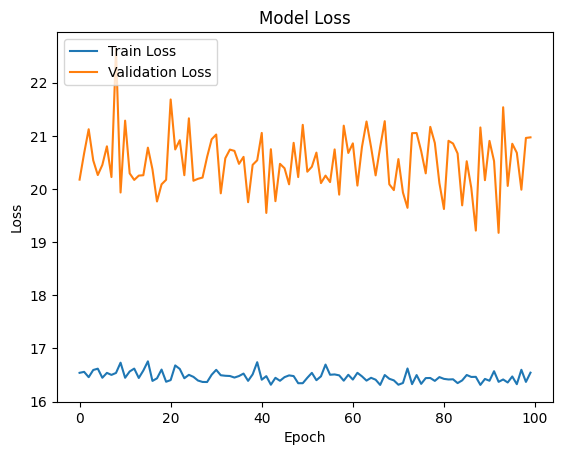

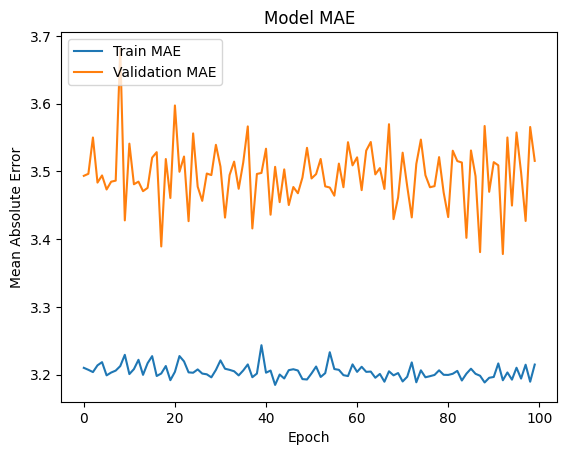

In [ ]:
if history.history:
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()
    # Plot the training and validation loss over the epochs to visualize the model's performance.
    plt.plot(history.history.get('mae', []), label='Train MAE')
    plt.plot(history.history.get('val_mae', []), label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper left')
    plt.show()
    # Plot the training and validation mean absolute error over the epochs.

else:
    print("No training history available.")
    # Print a message if no training history is available.

In [ ]:
# Function to prepare a single molecule for prediction
def prepare_molecule(smiles):
    adj, features = smiles_to_graph(smiles) # Convert the SMILES string to a graph representation.
    a = spektral.utils.normalized_adjacency(adj) # Normalize the adjacency matrix.
    features = features # No further processing needed for features.
    return features, a  # Return the node features and adjacency matrix.

def predict_heat_capacity(smiles, model):
    features, a = prepare_molecule(smiles) # Prepare the molecule for prediction.
    features = np.expand_dims(features, axis=0)  # Add batch dimension to the features.
    a = np.expand_dims(a, axis=0) # Add batch dimension to the adjacency matrix.
    i = np.zeros((1,), dtype=int) # Create a dummy batch index tensor.
    prediction = model.predict([features, a, i])  # Make the prediction using the model.
    return prediction[0][0] # Return the predicted heat capacity.

In [ ]:
smiles_example = input("Enter your smile string: ") # Get a SMILES string as input from the user.
predicted_cv = predict_heat_capacity(smiles_example, model) # Predict the heat capacity for the input SMILES string.
print(f'Predicted Heat Capacity (Cv) for SMILES "{smiles_example}": {predicted_cv} cal/(mol K)')
# Print the predicted heat capacity for the given SMILES string.

Enter your smile string: C
1/1 [==============================] - 0s 23ms/step
Predicted Heat Capacity (Cv) for SMILES "C": [0.75573945] cal/(mol K)


In [ ]:
model.save_weights('gnn_model_weights.h5') # Save the model weights to a file for future use.